In [1]:
import math, random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import cvxpy as cv

# Gene Expression model

A gene can either be on or off, in the on state a molecule M can be created, M degrades regardless of the gene state:

$ G_{off} \underset{k_{off}}{\stackrel{k_{on}}{\rightleftharpoons}} G_{on} $

$ G_{on} \stackrel{k_{tx}}\longrightarrow G_{on} + M $

$ M \stackrel{k_{deg}}\longrightarrow \varnothing $

However, in practice we can only observe the state/number of molecules M, not the state of gene expression:

We observe the marginal $\bar{p}(m)$ and not $p(m,0)$ or $p(m,1)$

State space:

$ (m,g) \in \mathbb{N} \times \{0,1\} $ where g = 0 corresponds to $ G_{off} $ and g = 1 to $ G_{on} $

# Simulation

First we need to simulate paths of the model, so long term averages to approximate the stationary distribution can be found

Use Gillespie to simulate exponential holding times, and transition probabilities given reaction rates:

In [2]:
def sample_path_gene(initial_state, params, tmax, plot=False):
    """
    Simulate a sample path of gene expression
    start at initial state, run until time tmax, rates in params
    return visited states and jump times
    """

    # initialise time and state (also store jump times)
    t = 0
    path = [(initial_state[0],initial_state[1])]
    jump_times = [0]
    k_on, k_off, k_tx, k_deg = params[0], params[1], params[2], params[3]

    # simulate until stopping time
    while t < tmax:
        # simulate holding time of current state (m,g)
        m, g = path[-1][0], path[-1][1]

        # define rates
        # q(x,x+(0,1)): gene turns on if off
        q_on = (1 - g) * k_on
        # q(x,x+(0,-1)): gene turns off if on
        q_off = g * k_off
        # q(x,x+(1,0)): transscription if gene on
        q_tx = g * k_tx
        # q(x,x+(-1,0)): degradation if  there are molecules
        q_deg = m * k_deg
        # -q(x,x): holding rate = sum q(x,y) over y
        q_hold = q_on + q_off + q_tx + q_deg

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold
        outcome = [1,2,3,4]
        prob = [q_on / q_hold, q_off / q_hold, q_tx / q_hold, q_deg / q_hold]
        jump = np.random.choice(outcome,p=prob)
        # jump to new state
        if jump == 1:
            path.append((m,g + 1))
        elif jump == 2:
            path.append((m,g - 1))
        elif jump == 3:
            path.append((m + 1,g))
        elif jump == 4:
            path.append((m - 1,g))

    if plot:
        # separate paths
        m_path = [state[0] for state in path]
        g_path = [state[1] for state in path]
        plt.scatter(jump_times, m_path, c=g_path, ec='k')

        # defined colour plotting
        #cmap, norm = mcolors.from_levels_and_colors([0, 1, 2], ['orange','blue'])
        #plt.scatter(jump_times, m_list, c=g_list, cmap=cmap, norm=norm)

    return path, jump_times

Short example path to check:
- yellow <=> gene on
- purple <=> gene off
- only increases m when gene on, constant decrease regardless of gene

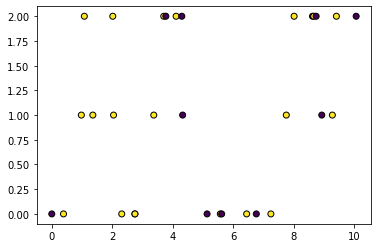

In [3]:
path, jump = sample_path_gene([0,0],[1,1,1,1],10,plot=True)

# Bootstrapping

Method:
- simulate path up to time t (sufficiently large for stationarity behaviour)
- record final state (a sample from the stationary distribution)
- repeat for n samples

bootstrapping:
- sample with replacement to obtain N bootstrap samples from the n values
- calculate the proportion of states x for each sample (estimate of p(x))
- find Confidence Intervals for each estimate


We first consider CIs for all states (m,g)

In [4]:
def bootstrap(x_list, initial_state, params, tmax, n, N, plot=False, printing=False):
    """
    x_list: states to calculate probabilities for
    initial state
    parameters
    tmax: time of path before sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples
    states = []
    for i in range(n):
        path, jumps = sample_path_gene(initial_state, params, tmax, plot=plot)
        states.append(path[-2]) # last state before tmax
    plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

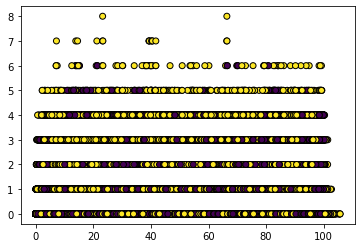

95% CI for p((0, 0)) is: (0.332, 0.393)


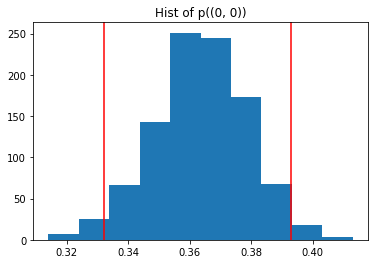

95% CI for p((0, 1)) is: (0.245, 0.3)


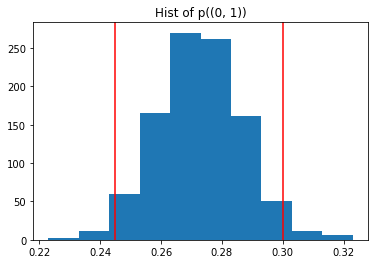

95% CI for p((1, 0)) is: (0.079, 0.115)


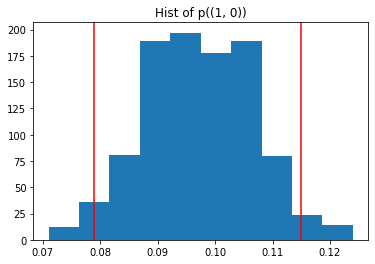

95% CI for p((1, 1)) is: (0.136, 0.182)


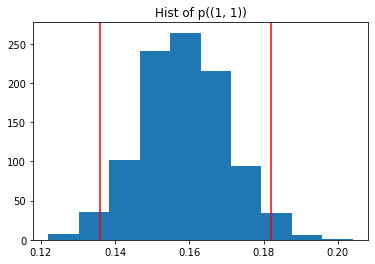

In [5]:
estimates, intervals = bootstrap([(0,0),(0,1),(1,0),(1,1)],[0,0],[1,1,1,1],100,1000,1000,plot=True,printing=True)

# Marginal

Now consider forming confidence intervals for the marginal stationary distribution of the chain, when no information on g is available.

Marginal: $ \bar{p}(m) = p(m,0) + p(m,1) $

#### Method 1:
- find CI's of individual states
- add pairs together to bound marginals

#### Method 2:
- perform simuation as before, but compute estimates and CI's only over m values
- directly gives CI on marginal

In [6]:
def bootstrap_marginal(m_list, initial_state, params, tmax, n, N, plot=False, printing=False):
    """
    m_list: marginal states of m to calculate probabilities for
    initial state
    parameters
    tmax: time of path before sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples: (m,g)
    states = []
    for i in range(n):
        path, jumps = sample_path_gene(initial_state, params, tmax, plot=plot)
        states.append(path[-2]) # last state before tmax
    plt.show()

    # simulate N bootstrap samples: estimates p(m) for each, and for each m
    estimates = [[] for x in m_list]
    for i in range(N):
        # sample with replacement from (m,g) samples
        sample = random.choices(states,k = n)
        # take just marginal m information
        m_sample = [state[0] for state in sample]
        # estimate p(m) from marginal info
        for i, x in enumerate(m_list):
            estimates[i].append(m_sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(m_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

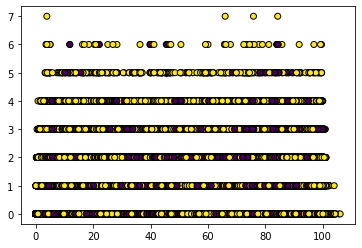

95% CI for p(0) is: (0.623, 0.68)


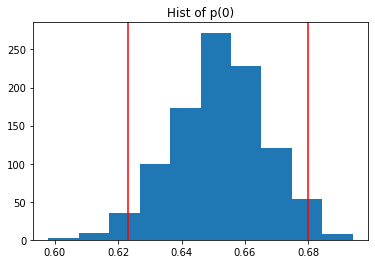

95% CI for p(1) is: (0.23197500000000001, 0.287025)


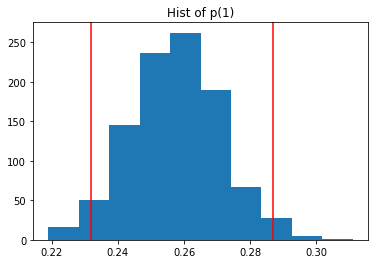

In [7]:
estimates_marginal, intervals_marginal = bootstrap_marginal([0,1],[0,0],[1,1,1,1],100,1000,1000,plot=True,printing=True)

Compare to sum of individual CI's:

#### But

Problems with summing CIs, so just directly find marginal

In [8]:
print(f"Direct p(0) CI: {intervals_marginal[0]}")
# p(0) = p(0,0) + p(0,1)
print(f"Sum p(0) CI: [{intervals[0][0] + intervals[1][0]},{intervals[0][1] + intervals[1][1]}]")

print(f"Direct p(1) CI: {intervals_marginal[1]}")
# p(1) = p(1,0) + p(1,1)
print(f"Sum p(1) CI: [{intervals[2][0] + intervals[3][0]},{intervals[2][1] + intervals[3][1]}]")

Direct p(0) CI: [0.623 0.68 ]
Sum p(0) CI: [0.577,0.6930000000000001]
Direct p(1) CI: [0.231975 0.287025]
Sum p(1) CI: [0.21500000000000002,0.297]


# Linear Program

Using bootstrap confidence intervals as bounds on the stationary distribution form LPs to bound parameters

### Step 1: All states
- initially find bounds for each state (m,g), use all information to solve LP

In [9]:
states = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1),(5,0),(5,1),(6,0),(6,1)]
estimates_test, intervals_test = bootstrap(states,[0,0],[1,1,0.5,1],100,1000,1000,plot=False,printing=True)

95% CI for p((0, 0)) is: (0.406, 0.464)
95% CI for p((0, 1)) is: (0.323, 0.383)
95% CI for p((1, 0)) is: (0.063, 0.095)
95% CI for p((1, 1)) is: (0.081, 0.119)
95% CI for p((2, 0)) is: (0.004, 0.016)
95% CI for p((2, 1)) is: (0.013, 0.030024999999999975)
95% CI for p((3, 0)) is: (0.0, 0.003)
95% CI for p((3, 1)) is: (0.0, 0.007)
95% CI for p((4, 0)) is: (0.0, 0.0)
95% CI for p((4, 1)) is: (0.0, 0.003)
95% CI for p((5, 0)) is: (0.0, 0.0)
95% CI for p((5, 1)) is: (0.0, 0.0)
95% CI for p((6, 0)) is: (0.0, 0.0)
95% CI for p((6, 1)) is: (0.0, 0.0)


In [10]:
# number of equations used (rows of Q)
N = 3

# create Qr matrices:
# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
        np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
         np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
        np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
         np.diag([1 for x in range(0,N)],2))[:-2, :]

# bounds from CI
pl = [intr[0] for intr in intervals_test]
pu = [intr[1] for intr in intervals_test]

# define bounds
pl = np.array(pl)[:N + 2]
pu = np.array(pu)[:N + 2]

# NOTE: truncate to N + 2, as 2 rows above diag, so Nth equation has N + 2 p's

# Construct the problem.
#k_on = cv.Variable(1)
k_on = 1
#k_off = cv.Variable(1)
k_off = 1
k_tx = cv.Variable(1)
#k_tx = 0.5
#k_deg = cv.Variable(1)
k_deg = 1
z_on = cv.Variable(N + 2)
z_off = cv.Variable(N + 2)
z_tx = cv.Variable(N + 2)
z_deg = cv.Variable(N + 2)
objective_max = cv.Maximize(k_tx)
objective_min = cv.Minimize(k_tx)
constraints = [Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
               k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
               k_on * pl <= z_on, z_on <= k_on * pu,
               k_off * pl <= z_off, z_off <= k_off * pu,
               k_tx * pl <= z_tx, z_tx <= k_tx * pu,
               k_deg * pl <= z_deg, z_deg <= k_deg * pu,
               ]
prob_max = cv.Problem(objective_max, constraints)
prob_min = cv.Problem(objective_min, constraints)   

# Print result.
result_max = prob_max.solve()
print(prob_max.status)
print("\nThe upper bound is", prob_max.value)
print(f"k_tx: {k_tx.value}")
result_min = prob_min.solve()
print(prob_min.status)
print("\nThe lower bound is", prob_min.value)
print(f"k_tx: {k_tx.value}")

optimal

The upper bound is 0.5913312693585061
k_tx: [0.59133127]
optimal

The lower bound is 0.37597911225387765
k_tx: [0.37597911]


Results:

Using k_tx = 0.5, all others fixed to 1

- Using N equations uses N + 2 p's, so after N = 3 bounds happen to be infeasible e.g. 5th p bounds may be wrong
- However, good bounds on k_tx = 0.5 after only a few equations:

N = 1: no bounds (no k_tx in first equations) \
N = 2: [0.44, 0.53] \
N = 3: [0.44, 0.51]


### Step2: Marginal states

- use only bounds on states of m: $ \bar{p}(m) = p(m,0) + p(m,1) $

In [11]:

def gene_expression_LP(params, N, bounds, printing=False):
	# N = number of equations used (rows of Q)
	# NOTE: restrict to even atm (as p's enter as pairs)

	# number of marginals used
	M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
	Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
	Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
	Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
	Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
			np.diag([1 for x in range(0,N)],2))[:-2, :]

	# bounds from CI, on marginal
	pl = [intr[0] for intr in bounds]
	pu = [intr[1] for intr in bounds]

	# define bounds
	pl = np.array(pl)[:M]
	pu = np.array(pu)[:M]

	# NOTE: need different cutoff: n p's <=> n/2 marginals

	# marginal = A @ p
	A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.

	# Variables
	k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
	if k1 == "v":
		k_on = cv.Variable(1)
	else:
		k_on = k1
	if k2 == "v":
		k_off = cv.Variable(1)
	else:
		k_off = k2
	if k3 == "v":
		k_tx = cv.Variable(1)
	else:
		k_tx = k3
	if k4 == "v":
		k_deg = cv.Variable(1)
	else:
		k_deg = k4
	z_on = cv.Variable(N + 2)
	z_off = cv.Variable(N + 2)
	z_tx = cv.Variable(N + 2)
	z_deg = cv.Variable(N + 2)

	# Objective
	var = "k_tx"
	objective_max = cv.Maximize(k_tx)
	objective_min = cv.Minimize(k_tx)

	# Constraints: Qp = 0, kr > 0, marginal bounds, joint prob in [0,1]
	constraints = [Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
			z_on <= k_on, z_off <= k_off, z_tx <= k_tx, z_deg <= k_deg,
			#z_on >= 0.001 * k_on, z_off >= 0.001 * k_off, z_tx >= 0.001 * k_tx, z_deg >= 0.001 * k_deg,
			z_on >= 0, z_off >= 0, z_tx >= 0, z_deg >= 0,
			k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
			k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
			k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
			k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
			k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
			]

	# define
	prob_max = cv.Problem(objective_max, constraints)
	prob_min = cv.Problem(objective_min, constraints)   

	# Print results
	result_max = prob_max.solve()
	if printing:
		print(f"Upper bound status: {prob_max.status}")
		print(f"\nUpper bound on {var}: {prob_max.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	result_min = prob_min.solve()
	if printing:
		print(f"\nLower bound status: {prob_min.status}")
		print(f"\nLower bound on {var}: {prob_min.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	return prob_max.value, prob_min.value

In [12]:
# attempt different parameters
states = [x for x in range(10)]
estimates_marginal, intervals_marginal = bootstrap_marginal(states,[0,0],[0.8,0.2,0.5,1],100,2000,2000,plot=False,printing=True)

95% CI for p(0) is: (0.6585, 0.699)
95% CI for p(1) is: (0.2445, 0.284)
95% CI for p(2) is: (0.036, 0.0545)
95% CI for p(3) is: (0.0064875, 0.0155)
95% CI for p(4) is: (0.0, 0.0035)
95% CI for p(5) is: (0.0, 0.0)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)


In [13]:
gene_expression_LP(["v","v","v",1],8,intervals_marginal,printing=True)

Upper bound status: unbounded

Upper bound on k_tx: inf

z_on: None
z_off: None
z_tx: None
z_deg: None

Lower bound status: optimal

Lower bound on k_tx: 0.3497854076868829

z_on: [0.32874121 0.23177744 0.08053386 0.13454594 0.01278793 0.02258041
 0.00324437 0.00538625 0.0008683  0.0008683 ]
z_off: [0.35647732 0.24558015 0.08470191 0.14688498 0.01367796 0.0252489
 0.00362943 0.00629654 0.00093771 0.00093771]
z_tx: [-8.92165394e-12  2.44500000e-01  4.49178190e-02  4.53487327e-02
  4.55805762e-03  1.07284268e-02  1.47126672e-03  2.34090715e-03
  3.71263862e-04  3.71263862e-04]
z_deg: [0.3391417  0.3391417  0.08316106 0.16133894 0.01680994 0.02853879
 0.00434898 0.00637945 0.00129681 0.0010441 ]


(inf, 0.3497854076868829)

# Results

The joint probabilities (multipied be rates to get z's) only occur as sums of pairs, so had problem of taking negative values, seen by negative z's. So, enforce bounds of [0,1] on p's => bounds of [0, kr] on z's (as well as all rates kr > 0)

- These constraints allow a lower bound to be found, possibly converging to true value? (or true range of possible values given data)

However, a non-zero lower bound on p's/z's is needed for an upper bound on the LP:
- using e.g. 0.01 as a bound on p is enough, but reducing in magnitude increaes upper bound, and not rigorous (may not always be true)

# Test solution lower bound
- simulate many marginal bounds e.g. 10+
- solve LP using increasing numbers of equations/bounds
- test if lower bound of solution converges to true value of parameter (or true range given input bounds)

In [63]:
# simulate marginal bounds
states = [x for x in range(12)]
estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[1,1,0.5,1],1000,20000,20000,plot=False,printing=True)

95% CI for p(0) is: (0.7793, 0.7907)
95% CI for p(1) is: (0.1752, 0.1858)
95% CI for p(2) is: (0.0286, 0.03345)
95% CI for p(3) is: (0.00245, 0.004)
95% CI for p(4) is: (0.0001, 0.00055)
95% CI for p(5) is: (0.0, 0.00015)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)
95% CI for p(10) is: (0.0, 0.0)
95% CI for p(11) is: (0.0, 0.0)


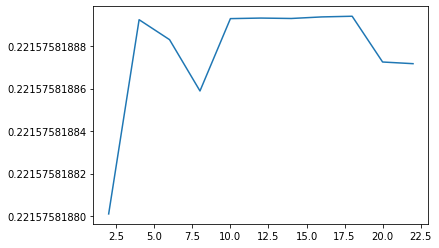

In [76]:
# increase number of equations/marginals used
equations_used = []
solution_lower = []
for N in range(2,24,2):
    # solve LP
    upper_bound, lower_bound = gene_expression_LP(["v","v","v",1],N,intervals_test)
    equations_used.append(N)
    solution_lower.append(lower_bound)
plt.ticklabel_format(useOffset=False)
plt.plot(equations_used,solution_lower)

Lower bound on k_tx doesn't seem to improve as more equations added

# Additional Constraints

Bounding joint probabilities by [0,1] allowed a lower bound on the LP, but a non-zero lower bound on p is needed for an upper bound on the LP. Using e.g. 0.01 is just an approximation, and may not be true.

### Frechet bounds:

max{0, P(X) + P(Y) - 1} < P(X n Y) < min{P(X), P(Y)}

Applying to marginals of M and G, where P(G = 1) = k_on / k_on + k_off, can bound joint probabilities:

In [15]:
# simulate marginal bounds
estimates_test, intervals_test = bootstrap_marginal([x for x in range(5)],[0,0],[0.8,0.2,0.5,1],100,1000,1000,plot=False,printing=False)
# form bound vectors (on marginal)
pl = np.array([intr[0] for intr in intervals_test])
pu = np.array([intr[1] for intr in intervals_test])
# form doubled bound vectors
pdl = np.repeat(pl,2)
pdu = np.repeat(pu,2)
# form bounds on joint probs
k1 = 0.8
k2 = 0.2
kv = [k2 if x % 2 else k1 for x in range(10)]
z1_lb = k1 * pdl + k2 * pdl - k2 * pdu - kv
z2_lb = k1 * pdl + k2 * pdl - k1 * pdu - kv
print(f"z1 lb: \n {z1_lb}")
print(f"\nz2 lb: \n {z2_lb}")
zsum_lb = (k1 + k2) * pdl - kv
print(f"\nz1 + z2 lb: \n {zsum_lb}")

z1 lb: 
 [-0.278205  0.321795 -0.634225 -0.034225 -0.7744   -0.1744   -0.799
 -0.199    -0.8      -0.2     ]

z2 lb: 
 [-0.71082  -0.11082  -0.796825 -0.196825 -0.8146   -0.2146   -0.808
 -0.208    -0.8      -0.2     ]

z1 + z2 lb: 
 [-0.134     0.466    -0.580025  0.019975 -0.761    -0.161    -0.796
 -0.196    -0.8      -0.2     ]


See above that only a few of the lower bounds on z1 and z2 are non-negative, can cover this by still using [0,kr] bounds, but means that only a few variables will now have tighter bounds

Can also bound the sum of z1 and z2 terms

In [17]:
def gene_expression_LP_2(params, N, bounds, printing=False):
	# N = number of equations used (rows of Q)
	# NOTE: restrict to even atm (as p's enter as pairs)

	# number of marginals used
	M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
	Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
	Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
	Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
	Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
			np.diag([1 for x in range(0,N)],2))[:-2, :]

	# bounds from CI, on marginal
	pl = [intr[0] for intr in bounds]
	pu = [intr[1] for intr in bounds]

	# define bounds
	pl = np.array(pl)[:M]
	pu = np.array(pu)[:M]

	# form doubled bounds
	pdl = np.repeat(pl,2)
	pdu = np.repeat(pu,2)

	# NOTE: need different cutoff: n p's <=> n/2 marginals

	# marginal = A @ p
	A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.

	# Variables
	k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
	if k1 == "v":
		k_on = cv.Variable(1)
	else:
		k_on = k1
	if k2 == "v":
		k_off = cv.Variable(1)
	else:
		k_off = k2
	if k3 == "v":
		k_tx = cv.Variable(1)
	else:
		k_tx = k3
	if k4 == "v":
		k_deg = cv.Variable(1)
	else:
		k_deg = k4
	z_on = cv.Variable(N + 2)
	z_off = cv.Variable(N + 2)
	z_tx = cv.Variable(N + 2)
	z_deg = cv.Variable(N + 2)

	# form bounds
	kv = np.array([k_off if x % 2 else k_on for x in range(N + 2)])
	z1_lb = k_on * pdl + k_off * pdl - k_off * pdu - kv
	z2_lb = k_on * pdl + k_off * pdl - k_on * pdu - kv
	zsum_lb = (k1 + k2) * pdl - kv

	print(z1_lb)
	print(z2_lb)
	print(zsum_lb)

	# Objective
	var = "k_tx"
	objective_max = cv.Maximize(k_tx)
	objective_min = cv.Minimize(k_tx)

	# Constraints
	constraints = [Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
			z_on <= k_on * pdu, z_off <= k_off * pdu, z_tx <= k_tx * pdu, z_deg <= k_deg * pdu,
			z_on >= z1_lb, z_off >= z2_lb, z_on + z_off >= zsum_lb,
			z_on >= 0, z_off >= 0, z_tx >= 0, z_deg >= 0,
			k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
			k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
			k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
			k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
			k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
			]

	# define
	prob_max = cv.Problem(objective_max, constraints)
	prob_min = cv.Problem(objective_min, constraints)   

	# Print results
	result_max = prob_max.solve()
	if printing:
		print(f"Upper bound status: {prob_max.status}")
		print(f"\nUpper bound on {var}: {prob_max.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	result_min = prob_min.solve()
	if printing:
		print(f"\nLower bound status: {prob_min.status}")
		print(f"\nLower bound on {var}: {prob_min.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	return prob_max.value, prob_min.value

In [20]:
# simulate marginal bounds
states = [x for x in range(10)]
estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[0.8,0.2,0.5,1],100,1000,1000,plot=False,printing=True)

95% CI for p(0) is: (0.653, 0.7120249999999999)
95% CI for p(1) is: (0.224, 0.277)
95% CI for p(2) is: (0.043, 0.073)
95% CI for p(3) is: (0.002, 0.012)
95% CI for p(4) is: (0.0, 0.003)
95% CI for p(5) is: (0.0, 0.0)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)


In [24]:
gene_expression_LP_2([0.8,0.2,"v",1],8,intervals_test,printing=True)

[-0.289405  0.310595 -0.6314   -0.0314   -0.7716   -0.1716   -0.8004
 -0.2004   -0.8006   -0.2006  ]
[-0.71662 -0.11662 -0.7976  -0.1976  -0.8154  -0.2154  -0.8076  -0.2076
 -0.8024  -0.2024 ]
[-0.147  0.453 -0.576  0.024 -0.757 -0.157 -0.798 -0.198 -0.8   -0.2  ]
Upper bound status: unbounded

Upper bound on k_tx: inf

z_on: None
z_off: None
z_tx: None
z_deg: None

Lower bound status: optimal

Lower bound on k_tx: 0.3145956953733184

z_on: [0.09950392 0.43912922 0.01975682 0.17116407 0.00407916 0.03656514
 0.00078135 0.00386809 0.00072388 0.00062004]
z_off: [0.05551269 0.07940922 0.01633044 0.03304399 0.00325464 0.00895308
 0.00054519 0.00120928 0.00018215 0.00015565]
z_tx: [-5.72359013e-13  2.24000000e-01  2.69133362e-02  5.26343214e-02
  1.06459676e-02  7.87932410e-03  9.37219864e-04  2.00576955e-03
  3.14595695e-04  3.14595695e-04]
z_deg: [0.34126072 0.34126072 0.02009471 0.20390529 0.00680753 0.04582679
 0.00193361 0.00594571 0.00150568 0.00050009]


(inf, 0.3145956953733184)

# Assuming k1 (k_on) and k2 (k_off) known, to get (linear) bounds on all z's:

In [25]:
# simulate marginal bounds
estimates_test, intervals_test = bootstrap_marginal([x for x in range(5)],[0,0],[0.8,0.2,0.5,1],100,1000,1000,plot=False,printing=False)
# form bound vectors (on marginal)
pl = np.array([intr[0] for intr in intervals_test])
pu = np.array([intr[1] for intr in intervals_test])
# form doubled bounds
pdl = np.repeat(pl,2)
pdu = np.repeat(pu,2)
# form bounds on joint probs
k1 = 0.8
k2 = 0.2
k3 = 0.5
k4 = 1
kv = [k2 if x % 2 else k1 for x in range(10)]
z1_lb = k1 * pdl + k2 * pdl - k2 * pdu - kv
z2_lb = k1 * pdl + k2 * pdl - k1 * pdu - kv
z3_lb = (k1 * pdl + k2 * pdl - k2 * pdu - kv) * k3/k1
z4_lb = (k1 * pdl + k2 * pdl - k2 * pdu - kv) * k4/k1
zsum_lb = (k1 + k2) * pdl - kv
print(f"z1 lb: \n{z1_lb}")
print(f"z2 lb: \n{z2_lb}")
print(f"z3 lb: \n{z3_lb}")
print(f"z4 lb: \n{z4_lb}")
print(f"zsum lb: \n{zsum_lb}")

z1 lb: 
[-0.2982    0.3018   -0.6262   -0.0262   -0.769825 -0.169825 -0.7986
 -0.1986   -0.801    -0.201   ]
z2 lb: 
[-0.7188   -0.1188   -0.7978   -0.1978   -0.814225 -0.214225 -0.8094
 -0.2094   -0.804    -0.204   ]
z3 lb: 
[-0.186375    0.188625   -0.391375   -0.016375   -0.48114062 -0.10614063
 -0.499125   -0.124125   -0.500625   -0.125625  ]
z4 lb: 
[-0.37275     0.37725    -0.78275    -0.03275    -0.96228125 -0.21228125
 -0.99825    -0.24825    -1.00125    -0.25125   ]
zsum lb: 
[-0.158     0.442    -0.569     0.031    -0.755025 -0.155025 -0.795
 -0.195    -0.8      -0.2     ]


In [33]:
def gene_expression_LP_3(params, N, bounds, printing=False):
	# N = number of equations used (rows of Q)
	# NOTE: restrict to even atm (as p's enter as pairs)

	# number of marginals used
	M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
	Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
	Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
	Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
	Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
			np.diag([1 for x in range(0,N)],2))[:-2, :]

	# bounds from CI, on marginal
	pl = [intr[0] for intr in bounds]
	pu = [intr[1] for intr in bounds]

	# define bounds
	pl = np.array(pl)[:M]
	pu = np.array(pu)[:M]

	# form doubled bounds
	pdl = np.repeat(pl,2)
	pdu = np.repeat(pu,2)

	# NOTE: need different cutoff: n p's <=> n/2 marginals

	# marginal = A @ p
	A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.

	# Variables
	k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
	if k1 == "v":
		k_on = cv.Variable(1)
	else:
		k_on = k1
	if k2 == "v":
		k_off = cv.Variable(1)
	else:
		k_off = k2
	if k3 == "v":
		k_tx = cv.Variable(1)
	else:
		k_tx = k3
	if k4 == "v":
		k_deg = cv.Variable(1)
	else:
		k_deg = k4
	z_on = cv.Variable(N + 2)
	z_off = cv.Variable(N + 2)
	z_tx = cv.Variable(N + 2)
	z_deg = cv.Variable(N + 2)

	# form bounds
	kv = np.array([k_off if x % 2 else k_on for x in range(N + 2)])
	z1_lb = k_on * pdl + k_off * pdl - k_off * pdu - kv
	z2_lb = k_on * pdl + k_off * pdl - k_on * pdu - kv
	z3_lb = (k_on * pdl + k_off * pdl - k_off * pdu - kv) * k_tx/k_on
	z4_lb = (k_on * pdl + k_off * pdl - k_off * pdu - kv) * k_deg/k_on
	#zsum_lb = (k1 + k2) * pdl - kv
	

	if printing:
		print(z1_lb)
		print(z2_lb)
		print(z3_lb)
		print(z4_lb)
		print(zsum_lb)

	# Objective
	var = "k_tx"
	objective_max = cv.Maximize(k_tx)
	objective_min = cv.Minimize(k_tx)

	# Constraints
	constraints = [Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
			z_on <= k_on * pdu, z_off <= k_off * pdu, z_tx <= k_tx * pdu, z_deg <= k_deg * pdu,
			z_on >= z1_lb, z_off >= z2_lb, z_tx >= z3_lb, z_deg >= z4_lb, #z_on + z_off >= zsum_lb,
			z_on >= 0, z_off >= 0, z_tx >= 0, z_deg >= 0,
			k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
			k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
			k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
			k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
			k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
			]

	# define
	prob_max = cv.Problem(objective_max, constraints)
	prob_min = cv.Problem(objective_min, constraints)   

	# Print results
	result_max = prob_max.solve()
	if printing:
		print(f"Upper bound status: {prob_max.status}")
		print(f"\nUpper bound on {var}: {prob_max.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	result_min = prob_min.solve()
	if printing:
		print(f"\nLower bound status: {prob_min.status}")
		print(f"\nLower bound on {var}: {prob_min.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	return prob_max.value, prob_min.value

In [34]:
# simulate marginal bounds
states = [x for x in range(10)]
estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[0.8,0.2,0.5,1],100,1000,1000,plot=False,printing=True)

95% CI for p(0) is: (0.653, 0.711)
95% CI for p(1) is: (0.224, 0.278)
95% CI for p(2) is: (0.042, 0.071)
95% CI for p(3) is: (0.003, 0.014)
95% CI for p(4) is: (0.0, 0.0030249999999999774)
95% CI for p(5) is: (0.0, 0.0)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)


In [35]:
gene_expression_LP_3([0.8,0.2,"v",1],10,intervals_test,printing=True)

[-0.2892    0.3108   -0.6316   -0.0316   -0.7722   -0.1722   -0.7998
 -0.1998   -0.800605 -0.200605 -0.8      -0.2     ]
[-0.7158  -0.1158  -0.7984  -0.1984  -0.8148  -0.2148  -0.8082  -0.2082
 -0.80242 -0.20242 -0.8     -0.2    ]
[-0.2892    0.3108   -0.6316   -0.0316   -0.7722   -0.1722   -0.7998
 -0.1998   -0.800605 -0.200605 -0.8      -0.2     ] @ Promote(var6502, (12,)) / Promote(0.8, (12,))
[-0.3615      0.3885     -0.7895     -0.0395     -0.96525    -0.21525
 -0.99975    -0.24975    -1.00075625 -0.25075625 -1.         -0.25      ]
[-0.158     0.442    -0.569     0.031    -0.755025 -0.155025 -0.795
 -0.195    -0.8      -0.2     ]
Upper bound status: optimal

Upper bound on k_tx: 0.715572715573285

z_on: [ 1.05502636e-01  4.33929053e-01  1.54002683e-02  1.77680036e-01
  3.84524108e-03  3.70092767e-02  6.32776284e-04  5.20086849e-03
  9.46734546e-05  9.86138899e-04  1.32096622e-16 -1.34044054e-14]
z_off: [ 5.71921229e-02  7.86120114e-02  1.42003734e-02  3.59888301e-02
  3.20008245e

(0.715572715573285, 0.31504922644096256)

# Results

The frechet bounds require p(x) + p(g) >= 1 to be active i.e. give a non-zero lower bound on p(x,g). For this reason gnerally need one of k1 / k1 + k2 and k2 / k1 + k2 to be large (k1, k2 very different) and x to be a state with a large p(x). Even with this, usually only get one positive lower bound for the joint probabilities.

These are enough to give upper and lower bounds on k_tx BUT, only when all other variables are specified (currently need k1 and k2 to be specified for linearity of constraints)

# Width

Using parameters that give positive bounds (and so upper and lower solution bounds) investigate how the width of solution bounds varies with sample size (and bootstrap size)

(0.23121387283085282,1.251263206247995)
(0.32197439807071004,0.7346525270026223)
(0.3630271902209296,0.7557971194343183)
(0.34834633158741984,0.6461988304168378)
(0.38625204582628897,0.695472251178416)


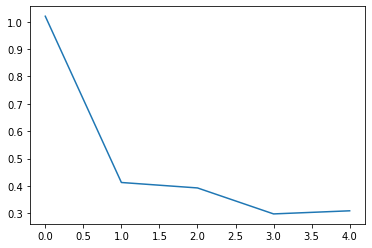

In [42]:
width = []
lbs = []
ubs = []
for N in [100,1000,2000,5000,10000]:
    states = [x for x in range(10)]
    estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[0.8,0.2,0.5,1],100,N,N,plot=False,printing=False)
    ub, lb = gene_expression_LP_3([0.8,0.2,"v",1],10,intervals_test,printing=False)
    ubs.append(ub)
    lbs.append(lb)
    print(f"({lb},{ub})")
    width.append(ub - lb)
plt.plot(width)    

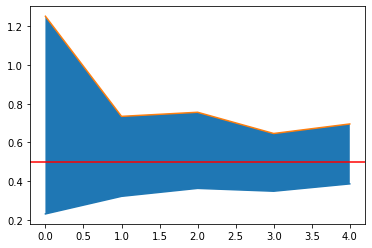

In [49]:
fig, ax = plt.subplots()
ax.plot(lbs)
ax.plot(ubs)
ax.fill_between([x for x in range(5)],lbs, ubs)
ax.axhline(0.5, color="red")

See that width does indeed decrease as the sample size increases: the outer approximation of the parameter becomes closer to the true value (as possible range given by data becomes smaller)

# Parameter Influence:

With the frechet bounds, and even [0,1] bounds, the ratio of k1 to k2 i.e. how "birth-death like" the process is, affects the quality of the bounds (bounds on solution in [0,1] case) (bounds on p's / z's in frechet case, and so also on solution). When k1 ~ k2 the frechet bounds do not give non-zero lower bounds, and so like [0,1] bounds give no upper bound on the solution, and poor lower bounds. When k1 >> k2, some (usually only 1) frechet lower bounds are non-zero and so give good solution bounds.

Plot the solution width/bounds for different k1,k2 values

(0.024665981499291813,inf)
(0.12773302646571594,inf)
(0.20595533497623478,inf)
(0.245161290312133,10.984615385223892)
(0.24415584415209257,1.254100529101815)
(0.29918032786738,0.8326530612255879)
(0.31559652246604897,0.7045565744414256)
(0.3319088319058679,0.6646734130648336)
(0.3771680041414802,0.4957376610507218)


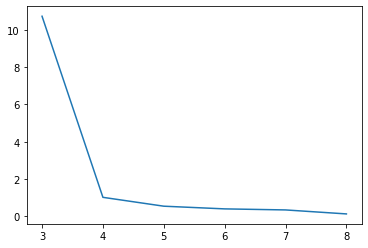

In [50]:
width = []
lbs = []
ubs = []
N = 1000
for k1 in [0.1,0.5,1,1.5,2,3,4,5,10]:
    states = [x for x in range(10)]
    estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[k1,1,0.5,1],100,N,N,plot=False,printing=False)
    ub, lb = gene_expression_LP_3([k1,1,"v",1],10,intervals_test,printing=False)
    ubs.append(ub)
    lbs.append(lb)
    print(f"({lb},{ub})")
    width.append(ub - lb)
plt.plot(width)    

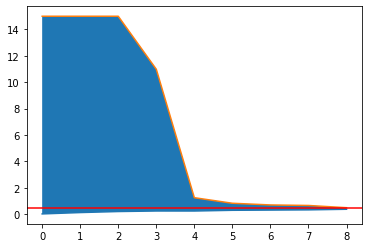

In [71]:
ubs_adj = [x if x < 15 else 15 for x in ubs]
fig, ax = plt.subplots()
ax.plot(lbs)
ax.plot(ubs_adj)
ax.fill_between([x for x in range(9)],lbs, ubs_adj)
ax.axhline(0.5, color="red")

(0.24641460234072,1.2905827787873498)
(0.3286713286645071,0.9446254071831008)
(0.3649270072899038,0.8471321048554316)
(0.3574529667135161,0.7032208589114051)
(0.3441049961378057,0.6451510895793505)
(0.3898437499974423,0.6307929969842875)
(0.3183619087677741,0.5390508276849675)
(0.39059613136644916,0.6283708251920853)
(0.36453147876812886,0.4815997487339583)
(0.3604826545991146,0.5761002716306527)
(0.46829268292564896,0.495619524417855)
(0.39484134488085615,0.4835399743743456)
(inf,-inf)


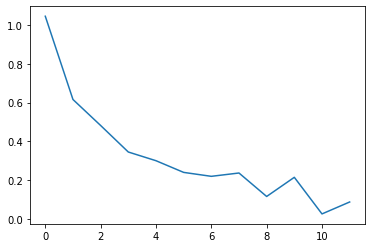

In [103]:
width = []
lbs = []
ubs = []
N = 1000
for k1 in [x for x in range(2,15)]:
    states = [x for x in range(10)]
    estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[k1,1,0.5,1],100,N,N,plot=False,printing=False)
    ub, lb = gene_expression_LP_3([k1,1,"v",1],10,intervals_test,printing=False)
    ubs.append(ub)
    lbs.append(lb)
    print(f"({lb},{ub})")
    width.append(ub - lb)
plt.plot(width)

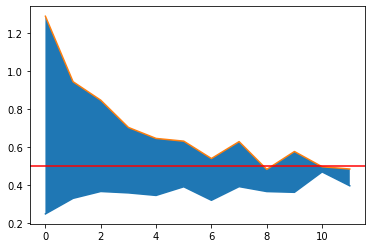

In [105]:
ubs_adj = [x if x < 2 else 2 for x in ubs]
lbs_adj = [x if x > 0 else 0 for x in lbs]
fig, ax = plt.subplots()
ax.plot(lbs_adj)
ax.plot(ubs_adj)
ax.fill_between([x for x in range(13)],lbs_adj, ubs_adj)
ax.axhline(0.5, color="red")